In [ ]:
from pathlib import Path
import tqdm

In [ ]:
from google.colab import drive
%load_ext google.colab.data_table
ps_cl_repo_path = 'train11/'
content_path = f'/content/drive/MyDrive/{ps_cl_repo_path}'
data_path = './data/'
drive.mount('/content/drive/')
content_path = Path(content_path)

Mounted at /content/drive/


In [ ]:
# Import packages
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt


mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])

unnormalise = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None):
    x = unnormalise(x)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'PS_GAN11'):
    os.makedirs(content_path/'PS_GAN11')


device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


In [ ]:
# Hyperparameter
batch_size = 48

#Transformations
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
     transforms.Resize([200,160]),
])

# Apply tranformations to data
train_dat = datasets.ImageFolder('/content/drive/MyDrive/train-11/', transform=transform)
test_dat = datasets.ImageFolder('/content/drive/MyDrive/test-11/', transform=transform)

# Load data
loader_train = DataLoader(train_dat, batch_size, shuffle=True, drop_last=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False, drop_last=True)

We'll visualize a subset of the test set:

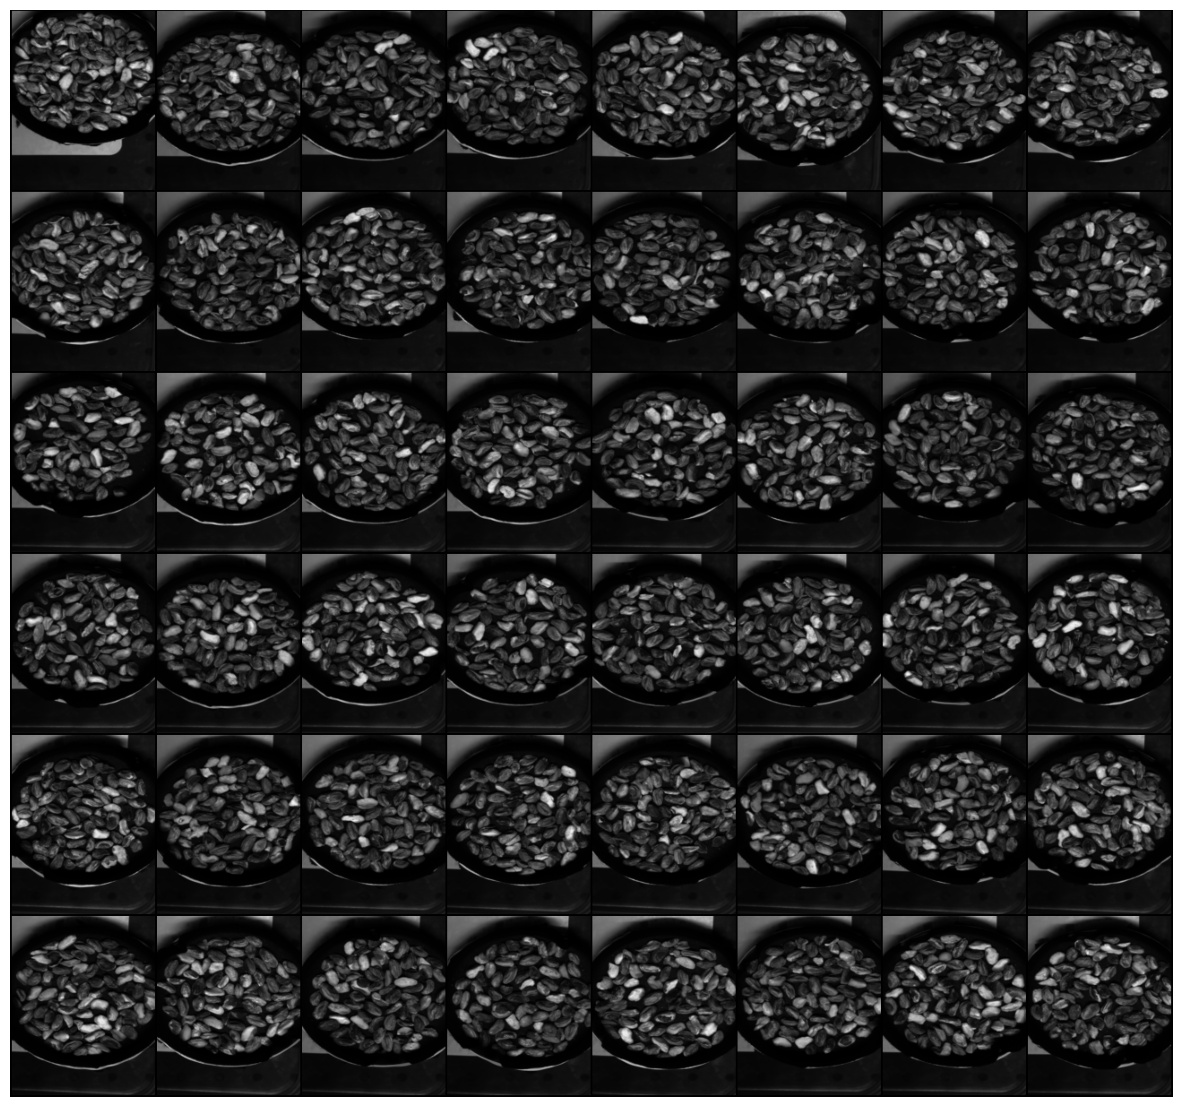

In [ ]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

In [ ]:
# Hyperparameters
num_epochs = 100
learning_rate_G = 0.002  # Generator learning rate
learning_rate_D = 0.001  # Discriminator learning rate
latent_vector_size = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 8, 5, 3, bias=False),
            nn.Tanh()
            # State size: (nc) x 200 x 160
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc) x 200 x 160
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf) x 100 x 80
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 2) x 50 x 40
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 4) x 25 x 20
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 8) x 13 x 10
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 16) x 7 x 5
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 32) x 4 x 3
            nn.Conv2d(ndf * 32, ndf * 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 64),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf * 64) x 2 x 2
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensure the output is 1x1
            nn.Conv2d(ndf * 64, 1, 1, 1, 0, bias=False),  # Final layer to reduce to a single value
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)  # Flatten to (batch_size)

In [ ]:
# Weight initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Initialisation flag
use_weights_init = True

# Generator parameters
nz = 100  # Size of the latent z vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in the generator
nc = 3  # Number of channels in the output image

# Initiate the generator model and move to device
model_G = Generator(nz, ngf, nc).to(device)

# Apply weights initialisation if the flag is set
if use_weights_init:
    model_G.apply(weights_init)

# Calculate the total number of trainable parameters in the generator
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

# Discriminator parameters
nc = 3  # Number of channels in the input images
ndf = 64  # Size of feature maps in the discriminator

# Initiate the discriminator model and move to device
model_D = Discriminator(nc, ndf).to(device)

# Apply weights initialisation if the flag is set
if use_weights_init:
    model_D.apply(weights_init)

# Calculate the total number of trainable parameters in the discriminator
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

# Print the total number of parameters in both models
print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3585920
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(8, 8), stride=(5, 5),

In [ ]:
# Binary Cross Entropy Loss Function
def loss_function(out, target):
    criterion = nn.BCELoss()
    loss = criterion(out, target)
    return loss

In [ ]:
# Optimisers
beta1 = 0.5
optimiserD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimiserG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

In [ ]:
# Function to add label noise
def add_label_noise(labels, noise_factor=0.1):
    # Ensure the noise is on the same device as the labels tensor
    noise = torch.rand(labels.size(), device=labels.device) * noise_factor
    noisy_labels = labels + noise * (torch.rand(labels.size(), device=labels.device) * 2 - 1)  # Add noise in the range [-noise_factor, noise_factor]
    return torch.clamp(noisy_labels, 0, 1)  # Values in range [0, 1]

# Lists to keep track of training losses
train_losses_G = []
train_losses_D = []

clip_value = 0.01  # Clipping value for gradient clipping

# Training loop
for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0

    # Progress bar for tracking training progress
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, (real_images, _) in enumerate(tepoch):
            # Ensure the model is using the GPU
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # Adjust labels to use soft and noisy labels
            real_labels = torch.full((batch_size,), 0.9, device=device, dtype=torch.float)
            real_labels_noisy = add_label_noise(real_labels, noise_factor=0.1)

            # Update the Discriminator network: maximise log(D(x)) + log(1 - D(G(z)))
            model_D.zero_grad()

            # Train with real images
            real_images = real_images.to(device)  # Move real_images to GPU
            output_real = model_D(real_images)

            # Debugging print statements
            # print(f"real_images shape: {real_images.shape}")
            # print(f"output_real shape: {output_real.shape}")
            # print(f"real_labels_noisy shape: {real_labels_noisy.shape}")

            # Ensure real_labels_noisy matches the shape of output_real
            errD_real = loss_function(output_real, real_labels_noisy)
            D_x = output_real.mean().item()

            # Train with fake images
            fake_labels = torch.full((batch_size,), 0.1, device=device, dtype=torch.float)
            fake_labels_noisy = add_label_noise(fake_labels, noise_factor=0.1)

            # Generate fake images and train with fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)  # Move noise to GPU
            fake_images = model_G(noise)
            output_fake = model_D(fake_images.detach())

            # Debugging print statements
            # print(f"fake_images shape: {fake_images.shape}")
            # print(f"output_fake shape: {output_fake.shape}")
            # print(f"fake_labels_noisy shape: {fake_labels_noisy.shape}")

            errD_fake = loss_function(output_fake, fake_labels_noisy)
            D_G_z1 = output_fake.mean().item()

            # Update Discriminator
            errD = errD_real + errD_fake
            errD.backward()
            torch.nn.utils.clip_grad_norm_(model_D.parameters(), clip_value)  # Apply gradient clipping to discriminator
            optimizerD.step()

            # Update the Generator network: maximise log(D(G(z)))
            model_G.zero_grad()
            output = model_D(fake_images)

            # Debugging print statements
            # print(f"output shape: {output.shape}")
            # print(f"real_labels_noisy shape: {real_labels_noisy.shape}")

            errG = loss_function(output, real_labels_noisy)
            errG.backward()
            torch.nn.utils.clip_grad_norm_(model_G.parameters(), clip_value)  # Apply gradient clipping to generator
            optimizerG.step()

            D_G_z2 = output.mean().item()

            # Update losses for logging
            train_loss_D += errD.item()
            train_loss_G += errG.item()

            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                   Loss_D=errD.item(), Loss_G=errG.item())

    # Logging outside the batch loop for each epoch
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

    # Save real and fake samples for the first epoch
    if epoch == 0:
        save_image(denorm(real_images.cpu()).float(), content_path/'PS_GAN11/real_samples2.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'PS_GAN11/fake_samples2_epoch_%03d.png') % epoch)

# Save models
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), f'{content_path}/PS_GAN11/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake.detach())), f'{content_path}/PS_GAN11/GAN_D_model.pth')


Epoch 99: 100%|██████████| 6/6 [00:37<00:00,  6.17s/batch, D_G_z=0.134/0.117, D_x=0.896, Loss_D=0.683, Loss_G=1.97]


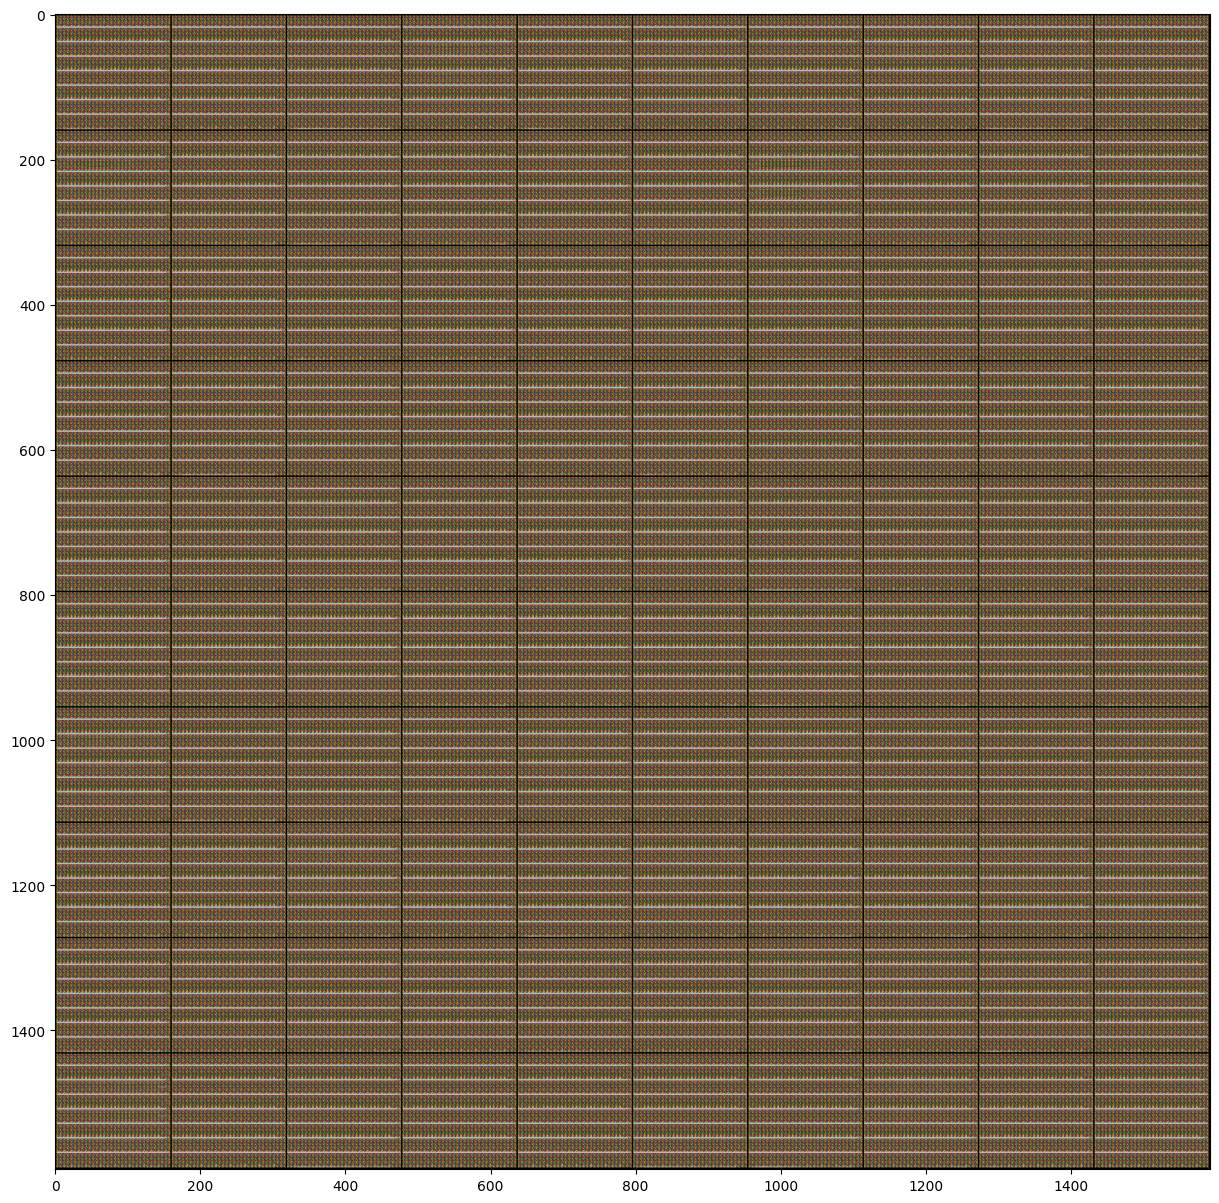

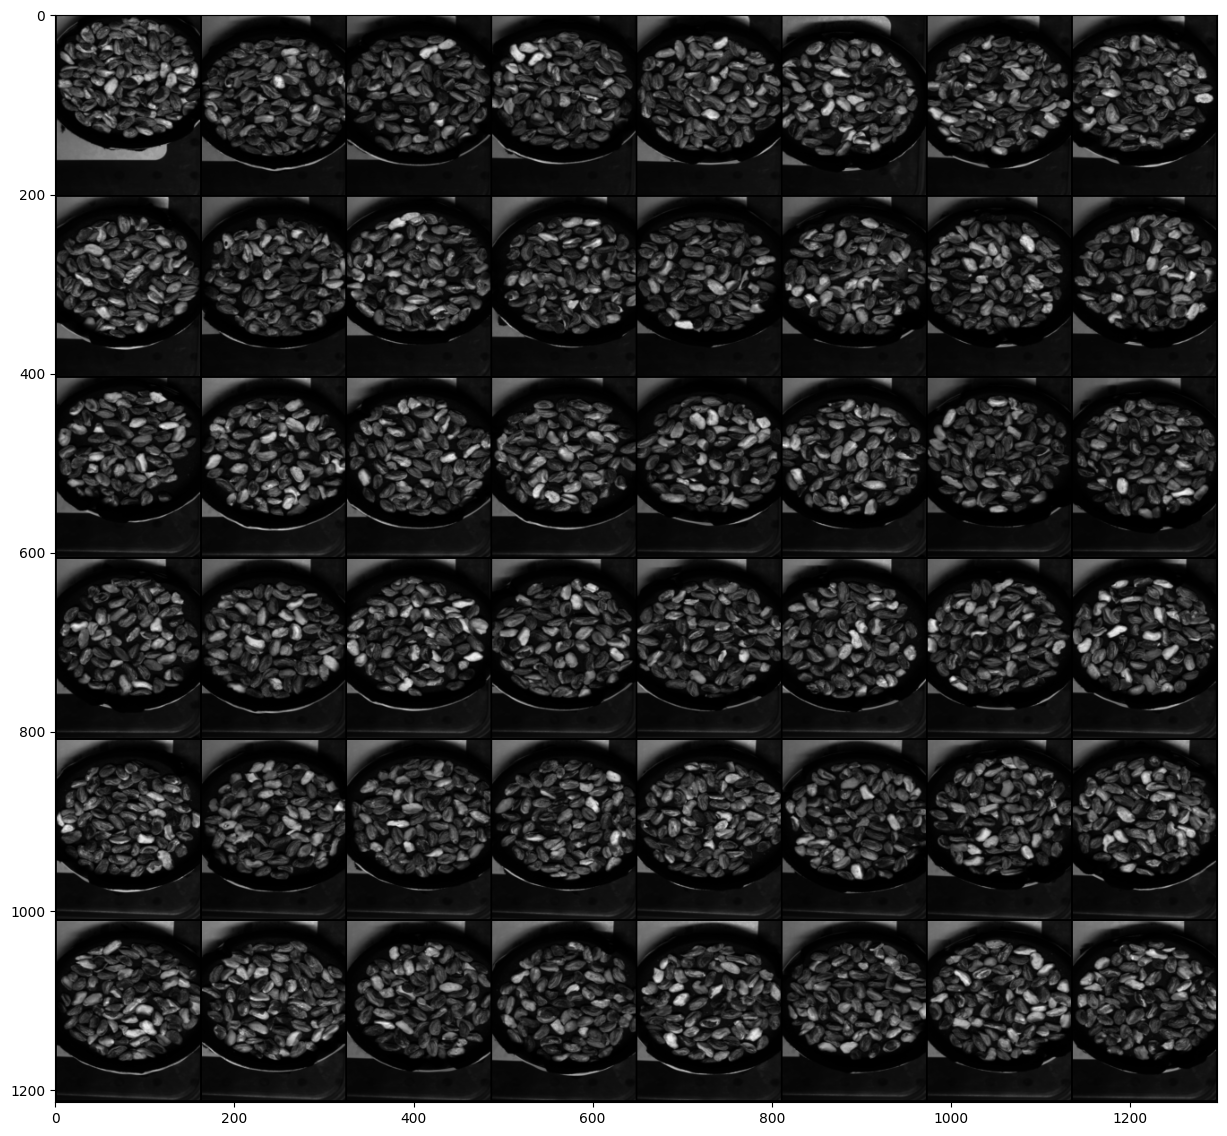

In [ ]:
# Generate noise input for visualisation
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # Visualise the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                          value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15, 15))
    save_image(generated, content_path/'PS_GANWHOLE/Teaching_final2.png')
    show(generated)  # Note these are now class-conditional images, columns represent classes 1-10

# Get a batch of test images
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]

# Visualise the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15, 15))
show(img)


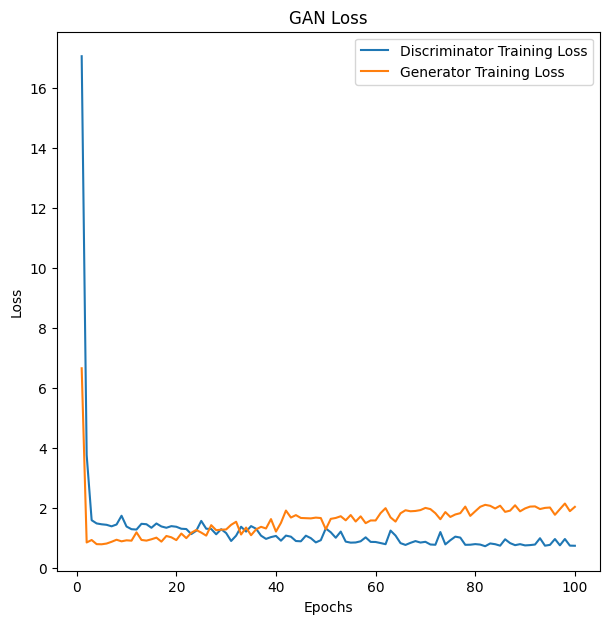

In [ ]:
# Plot loss curves
epochs = range(1, num_epochs + 1)

# Plotting
plt.figure(figsize=(7, 7))

plt.plot(epochs, train_losses_D, label='Discriminator Training Loss')
plt.plot(epochs, train_losses_G, label='Generator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend()